In [ ]:
!pip install -q formulaic

In [160]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Statistic
from scipy.stats import norm
from scipy.special import logit

# Feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Metrics
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

# Model
from sklearn.linear_model import LogisticRegression

# Параметр регуляризации V_cips
LAMBDA = 10

In [2]:
def data_preprocess(data):
    
    # Переводим date_time из str в datetime
    data['date_time'] = pd.to_datetime(data['date_time'])
    
    # Добавляем колонки hour и weekday
    data['hour'] = data['date_time'].dt.hour
    data['weekday'] = data['date_time'].dt.weekday
    
    # Удаляем колонки, которые по условию не нужны для 4го ДЗ
    data = data.drop(['campaign_clicks'], axis=1)
    
    return data

In [3]:
data = pd.read_csv('../data/data.csv')
data = data_preprocess(data)
data.head()

,date_time,zone_id,banner_id,oaid_hash,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks,hour,weekday
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1,0,0
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1,22,6
2,2021-09-26 23:57:20,2,2,2215519569292448030,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1,23,6
3,2021-09-27 00:04:30,3,3,6262169206735077204,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1,0,0
4,2021-09-27 00:06:21,4,4,4778985830203613115,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1,0,0


In [5]:
%%time
# Отделяем последний день и фильруем banner_id == banner_id0
first_days = data[data['date_time'].dt.date != dt.date(2021, 10, 2)]
first_days = first_days[first_days['banner_id'] == first_days['banner_id0']]

# Удаляем nan из колонок 'coeff_sum0', 'coeff_sum0', 'g0', 'g1' для последнего дня
last_day = data[data['date_time'].dt.date == dt.date(2021, 10, 2)]
last_day = last_day[last_day['banner_id'] == last_day['banner_id0']]
last_day = last_day.dropna(subset=['coeff_sum0', 'coeff_sum0', 'g0', 'g1'])

CPU times: user 7.83 s, sys: 1.32 s, total: 9.14 s
Wall time: 9.18 s


В 1м ДЗ в модели я использовал интеракции zone_id и banner_id, а также weekday и hour. Но так как здесь необходимо отдельно рассматривать banner_id0 и banner_id1, я не нашел способа сделать это при помощи трансформаций из sklearn, поэтому упростил модель из 1го ДЗ, убрав все интерацкии категориальных переменных.

In [6]:
%%time
# на вход препроцессору первой подается колонка 'banner_id', и потом следующие фичи:
non_banner_features = ['hour', 'weekday', 'zone_id', 'os_id', 'country_id']

transforms = ColumnTransformer([
    ('banner_one_hot', OneHotEncoder(sparse=True, handle_unknown= 'ignore'), [0]),
    ('others_one_hot', OneHotEncoder(sparse=True, handle_unknown= 'ignore'), [1, 2, 3, 4, 5]),
])

transforms.fit(first_days[['banner_id'] + non_banner_features].to_numpy())

CPU times: user 6.7 s, sys: 1.91 s, total: 8.61 s
Wall time: 8.88 s


ColumnTransformer(transformers=[('banner_one_hot',
                                 OneHotEncoder(handle_unknown='ignore'), [0]),
                                ('others_one_hot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 [1, 2, 3, 4, 5])])

In [7]:
%%time
# Получаем обработанный обучающий датасет, и 2 тестовых для 'banner_id0' и 'banner_id1'
X_train = transforms.transform(first_days[['banner_id'] + non_banner_features].to_numpy())
X_test0 = transforms.transform(last_day[['banner_id0'] + non_banner_features].to_numpy())
X_test1 = transforms.transform(last_day[['banner_id1'] + non_banner_features].to_numpy())

CPU times: user 6.84 s, sys: 1.65 s, total: 8.49 s
Wall time: 8.58 s


In [8]:
%%time
# Логостическая регрессия с регуляризацией как в 1м ДЗ
clf = LogisticRegression(solver='liblinear', C=0.1)
clf.fit(X_train, first_days['clicks'])

CPU times: user 1min 42s, sys: 5.99 s, total: 1min 48s
Wall time: 39.6 s


LogisticRegression(C=0.1, solver='liblinear')

In [9]:
# Предсказываем вероятности клика по баннерам
p_0 = clf.predict_proba(X_test0)[:, 1] # banner_id0
p_1 = clf.predict_proba(X_test1)[:, 1] # banner_id1

In [15]:
# Можем посчитать метрики, используя p_0, так как banner_id == banner_id0
print(f'log_loss: {log_loss(last_day["clicks"], p_0)}')
print(f'auc:      {roc_auc_score(last_day["clicks"], p_0)}')

log_loss: 0.13472047142122448
auc:      0.7905233278299567


### Вероятность что одна нормально распределенная с. в. больше другой:

$X_0 \sim \mathcal{N}(\texttt{coeff_sum0}, \texttt{g0}^2) \quad ; \quad X_1 \sim \mathcal{N}(\texttt{coeff_sum1}, \texttt{g1}^2)\quad $

пусть $D = X_1 - X_0$, тогда

$D \sim \mathcal{N}(\texttt{coeff_sum1} - \texttt{coeff_sum0}, \texttt{g0}^2 + \texttt{g1}^2)$

$P(X_0 > X_1) = P((X_1 - X_0) < 0) = P(D < 0) = F\left(\dfrac{0 - (\texttt{coeff_sum1} - \texttt{coeff_sum0})}{\sqrt{\texttt{g0}^2 + \texttt{g1}^2)}}\right) = F\left(\dfrac{\texttt{coeff_sum0} - \texttt{coeff_sum1})}{\sqrt{\texttt{g0}^2 + \texttt{g1}^2)}}\right)$

In [137]:
# Считаем pi_0 по формуле выше
pi_0 = norm.cdf(
    (last_day['coeff_sum0'] - last_day['coeff_sum1']) / 
    np.sqrt(last_day['g0'] ** 2 + last_day['g1'] ** 2))

# Считаем pi_1 заменяя coeff_sum0 и coeff_sum1 на логиты от предсказанных вероятностей
pi_1 = norm.cdf(
    (logit(p_0) - logit(p_1)) / 
    np.sqrt(last_day['g0'] ** 2 + last_day['g1'] ** 2))

# В процессе вычисления появились nan, inf и близкие к 0 значения pi_0, на которых возникает ошибка деления
# Отфильтруем такие значения
mask = np.isfinite(pi_0) * np.isfinite(pi_1) * (abs(pi_0) > np.finfo(np.float64).tiny)
print(f'Осталось {mask.sum() / len(pi_0):.2f}% данных')
print(f'min(pi_0) = {pi_0[mask].min():.2e}')

Осталось 0.91% данных
min(pi_0) = 2.24e-308


In [145]:
V_cips = np.mean(last_day['clicks'][mask] * np.minimum(pi_1[mask] / pi_0[mask], LAMBDA))
print(f'V_cips = {V_cips:.3f} при lambda = {LAMBDA}')

V_cips = 0.066 при lambda = 10


### Выбор параметра регуляризации логистической регресии на основе метрики $\hat{V}_{CIPS}(\pi, D_0)$

  0%|          | 0/5 [00:00<?, ?it/s]

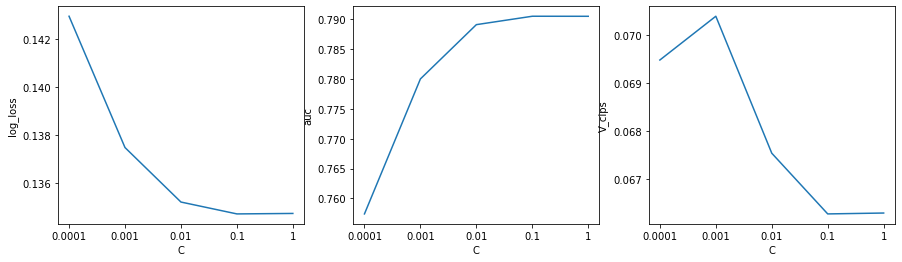

максимальный V_cips = 0.070 при регуляризации С = 0.001


In [213]:
C = [.0001, .001, .01, .1, 1]

def calc_V_cips(c):
    # Логостическая регрессия с заданым параметром регуляризации
    clf = LogisticRegression(solver='liblinear', C=c)
    clf.fit(X_train, first_days['clicks'])
    
    # Предсказываем вероятности клика по баннерам
    p_0 = clf.predict_proba(X_test0)[:, 1] # banner_id0
    p_1 = clf.predict_proba(X_test1)[:, 1] # banner_id1
    
    # Считаем log_loss и auc (для графиков)
    loss = log_loss(last_day["clicks"], p_0)
    auc = roc_auc_score(last_day["clicks"], p_0)
    
    # Считаем pi_0
    pi_0 = norm.cdf(
        (last_day['coeff_sum0'] - last_day['coeff_sum1']) / 
        np.sqrt(last_day['g0'] ** 2 + last_day['g1'] ** 2))

    # Считаем pi_1
    pi_1 = norm.cdf(
        (logit(p_0) - logit(p_1)) / 
        np.sqrt(last_day['g0'] ** 2 + last_day['g1'] ** 2))
    
    # Фильтруем значения
    mask = np.isfinite(pi_0) * np.isfinite(pi_1) * (abs(pi_0) > np.finfo(np.float64).tiny)
    
    # Считаем V_cips
    V_cips = np.mean(last_day['clicks'][mask] * np.minimum(pi_1[mask] / pi_0[mask], LAMBDA))
    
    return loss, auc, V_cips


def show_result():

    losses = [None] * len(C)
    aucs = [None] * len(C)
    Vs_cips = [None] * len(C)

    for i, c in (enumerate(pbar := tqdm(C))):
        pbar.set_description(f"processing C = {c}")

        loss, auc, V_cips = calc_V_cips(c)

        losses[i] = loss
        aucs[i] = auc
        Vs_cips[i] = V_cips
        
    # График
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].plot(x, losses)
    ax[0].set_ylabel('log_loss')

    ax[1].plot(x, aucs)
    ax[1].set_ylabel('auc')

    ax[2].plot(x, Vs_cips)
    ax[2].set_ylabel('V_cips')

    [a.set_xlabel('C') for a in ax]
    [a.set_xticks(x) for a in ax]
    [a.set_xticklabels(C) for a in ax]

    plt.show()

    print(f'максимальный V_cips = {np.max(Vs_cips):.3f} при регуляризации С = {C[np.argmax(Vs_cips)]}')
        
show_result()

### Выводы

По графикам видно, что метрика ${V}_{CIPS}$ действительно не коррелирует с log-loss и auc. В то время как минимум log-loss и максимум auc достигается при регуляризации $C = 0.1$, максимум ${V}_{CIPS}$ достигается при $C = 0.001$, а при больших значениях регуляризации начинает стремительно падать.